In [1]:
import random
from xgboost import XGBClassifier

In [2]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import cohen_kappa_score, make_scorer

In [3]:
from sklearn.datasets import load_digits

In [4]:
x_train, y_train = load_digits()['data'], load_digits()['target']

In [5]:
x_train.shape

(1797, 64)

In [6]:
img_1 = x_train[100].reshape((8,8))

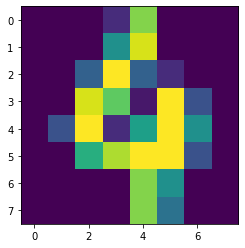

In [7]:
plt.imshow(img_1)

In [8]:
from deap import tools, base, creator, algorithms

In [9]:
creator.create("FitnessMax", base=base.Fitness, weights = (1.0,)) # Fitness function
creator.create("Individual",list,fitness = creator.FitnessMax) # Chromosome

In [10]:
def bin_array_to_int(bin_array):
    n = len(bin_array)
    int_val = 0.0
    for i in range(n):
        int_val += (2**(n-1-i)) * (bin_array[i])
    return int_val

In [11]:
def kappa_score(y_act, y_pred):
    return cohen_kappa_score(y_act, y_pred)

Kappa = make_scorer(kappa_score)

In [12]:
nGenes = 10
def evaluateFitness(individual, x_train=x_train, y_train=y_train):
#     print(individual)
    lr = np.round(1/(bin_array_to_int(individual[:int(nGenes/2)])+1e-4),3)
    n_estimators = int(bin_array_to_int(individual[int(nGenes/2):])+2)
    
#     print(lr, n_estimators)
    
    xgb = XGBClassifier(n_estimators= n_estimators, learning_rate=lr)
    
    return cross_val_score(xgb, X = x_train, y = y_train, cv=5, scoring=Kappa, n_jobs=-1).mean()    

In [13]:
toolbox = base.Toolbox()
toolbox.register("bool_attr", random.randint,0,1) # Gene
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.bool_attr, nGenes)
toolbox.register('population', tools.initRepeat, list, toolbox.individual)
toolbox.register("mate", tools.cxUniform)
toolbox.register("mutate", tools.mutFlipBit,indpb = 0.05)
toolbox.register("select",tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluateFitness)

In [14]:
pop = toolbox.population(n=10)
fitnesses = list(map(toolbox.evaluate, pop))

for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = [fit]
    
# fits = [ind.fitness.values[0] for ind in pop]
# fits

In [15]:
ind.fitness

deap.creator.FitnessMax((0.8194860444709351,))

In [16]:
gen = 0
max_gen = 10
CXPB = 0.7
MUTPB = 0.2

while gen < max_gen:
    gen += 1
    print("--Generation %i--" %gen)
    
    children = toolbox.select(pop, len(pop))
    children = list(map(toolbox.clone, children))
    
    for child1, child2 in zip(children[::2], children[1::2]):
        if random.random() < CXPB:
            toolbox.mate(child1, child2,indpb=0.7)
            del child1.fitness.values
            del child2.fitness.values
            
    for mutant in children:
        if random.random() < MUTPB:
            toolbox.mutate(mutant)
            del mutant.fitness.values
            
    invalid_ind = [ind for ind in children if not ind.fitness.values]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = [fit]
        
    pop[:] = children

--Generation 1--
--Generation 2--
--Generation 3--
--Generation 4--
--Generation 5--
--Generation 6--
--Generation 7--
--Generation 8--
--Generation 9--
--Generation 10--


In [17]:
fits = [ind.fitness.values[0] for ind in pop]
fits

[0.9023175761926778,
 0.9023175761926778,
 0.9023175761926778,
 0.9023175761926778,
 0.9023175761926778,
 0.9023175761926778,
 0.9035549054274663,
 0.9023175761926778,
 0.8973674767587962,
 0.8979864776964469]

[]

In [18]:
pop
# xxx.fitness.values = [fitnesses[1]]

[[0, 0, 1, 0, 0, 1, 0, 1, 0, 0],
 [0, 0, 1, 0, 0, 1, 0, 1, 0, 0],
 [0, 0, 1, 0, 0, 1, 0, 1, 0, 0],
 [0, 0, 1, 0, 0, 1, 0, 1, 0, 0],
 [0, 0, 1, 0, 0, 1, 0, 1, 0, 0],
 [0, 0, 1, 0, 0, 1, 0, 1, 0, 0],
 [0, 0, 1, 0, 0, 1, 1, 0, 0, 0],
 [0, 0, 1, 0, 0, 1, 0, 1, 0, 0],
 [0, 0, 1, 0, 1, 1, 0, 1, 0, 0],
 [0, 0, 1, 0, 1, 1, 0, 1, 0, 1]]

In [20]:
bin_array_to_int(pop[6][:int(nGenes/2)]), bin_array_to_int(pop[6][int(nGenes/2):])

(4.0, 24.0)

In [ ]:
1/22

# EM Clustering (Gaussian Mixture Model)

In [35]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

In [43]:
from tqdm import tqdm, tqdm_notebook

In [46]:
best_cluster = []
for nCluster in tqdm(range(2,21)):
    gmm = GaussianMixture(n_components=nCluster, max_iter=1000, n_init=30)
    gmm.fit(X = x_train)
    clus_gmm = gmm.predict(x_train)
    s = silhouette_score(X=x_train, labels=clus_gmm)
    best_cluster.append([s,clus_gmm, gmm])    

100%|██████████| 19/19 [03:20<00:00, 10.53s/it]


In [57]:
for j in range(len(best_cluster)):
    print(j, best_cluster[j][0])
best_cluster[17][2]

0 0.06451647703199051
1 0.029099319792413703
2 0.04296758052399649
3 0.05446245943157245
4 0.10238002308842767
5 0.06805893237505788
6 0.1304186037199928
7 0.13789505123193865
8 0.15613200683407744
9 0.14133115738901653
10 0.1438761524793432
11 0.15515168480249822
12 0.14984305768864434
13 0.1229552732322325
14 0.13049089947547726
15 0.17502251746816855
16 0.18099945726381594
17 0.18188729411840426
18 0.16216681314301695


GaussianMixture(max_iter=1000, n_components=19, n_init=30)

In [ ]:
# Optimum number of clusters is 19 as per GMM

In [48]:
from sklearn.manifold import TSNE

In [49]:
tsne = TSNE()

In [50]:
tsne_mat = tsne.fit_transform(x_train)

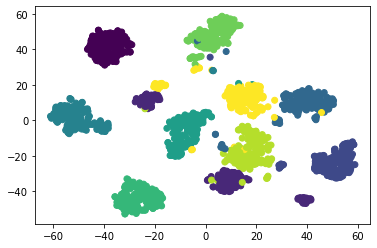

In [53]:
plt.scatter(tsne_mat[:,0],tsne_mat[:,1], c=y_train)